In [8]:
import matplotlib.pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline     

In [9]:
train_data_dir = '/home/mlab/Documents/brats_hl_data/train'
validation_data_dir = '/home/mlab/Documents/brats_hl_data/val'
# 44938
# 5616
nb_train_samples = 44938
nb_validation_samples = 5616
epochs = 8
batch_size = 128
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 44938 images belonging to 2 classes.
Found 5616 images belonging to 2 classes.


In [10]:
#uses a smal vggnet
#32->64->128->512
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid')) #uses sigmoid at the end because we onlu have two classes

W0216 09:35:28.779163 140375213623104 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0216 09:35:28.817338 140375213623104 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0216 09:35:28.822030 140375213623104 deprecation.py:506] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 512)       590336    
__________

In [12]:
#We use the RMSprop optimizer with a learning rate of 0.0001
#We use ninary_crossentropy loss because its a binary classification
#optimizer = Adam(learning_rate=lr_schedule(0))
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

W0216 09:35:28.871100 140375213623104 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0216 09:35:28.874930 140375213623104 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0216 09:35:28.878212 140375213623104 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
true_classes = train_generator.classes
print(true_classes)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

[0 0 0 ... 1 1 1]
['high', 'low']


In [14]:
# train the model on the new data for a few epochs
history =model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

Epoch 1/8
351/351 [==============================] - 568s 2s/step - loss: 0.6214 - acc: 0.6449 - val_loss: 0.5800 - val_acc: 0.6733
Epoch 2/8
351/351 [==============================] - 559s 2s/step - loss: 0.5550 - acc: 0.7023 - val_loss: 0.5152 - val_acc: 0.7380
Epoch 3/8
351/351 [==============================] - 557s 2s/step - loss: 0.5288 - acc: 0.7244 - val_loss: 0.4711 - val_acc: 0.7618
Epoch 4/8
351/351 [==============================] - 558s 2s/step - loss: 0.5031 - acc: 0.7394 - val_loss: 0.4630 - val_acc: 0.7751
Epoch 5/8
351/351 [==============================] - 558s 2s/step - loss: 0.4801 - acc: 0.7558 - val_loss: 0.4334 - val_acc: 0.7866
Epoch 6/8
351/351 [==============================] - 558s 2s/step - loss: 0.4581 - acc: 0.7704 - val_loss: 0.4093 - val_acc: 0.8039
Epoch 7/8
351/351 [==============================] - 557s 2s/step - loss: 0.4400 - acc: 0.7801 - val_loss: 0.3742 - val_acc: 0.8274
Epoch 8/8
351/351 [==============================] - 557s 2s/step - loss: 0.

In [15]:
# # #save the model
# model.save_weights('model_weights.h5')
# model.save('model_keras.h5')

In [16]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


In [17]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = (Y_pred<0.475).astype(np.int)

# print('Confusion Matrix')
# print(confusion_matrix(true_classes_1, y_pred))
# print('Classification Report')
# print(classification_report(validation_generator.classes, y_pred, 
#                             target_names=class_labels_1))


In [19]:
true_classes_1 = validation_generator.classes
print(true_classes)
class_labels_1 = list(validation_generator.class_indices.keys())
print(class_labels_1)

[0 0 0 ... 1 1 1]
['high', 'low']


In [20]:
confusion_matrix = metrics.confusion_matrix(true_classes_1,y_pred)
print(confusion_matrix)

[[1563 1212]
 [1618 1223]]


In [21]:
report= sklearn.metrics.classification_report(true_classes_1, y_pred, 
                                              target_names = class_labels_1)
print(report)

              precision    recall  f1-score   support

        high       0.49      0.56      0.52      2775
         low       0.50      0.43      0.46      2841

   micro avg       0.50      0.50      0.50      5616
   macro avg       0.50      0.50      0.49      5616
weighted avg       0.50      0.50      0.49      5616



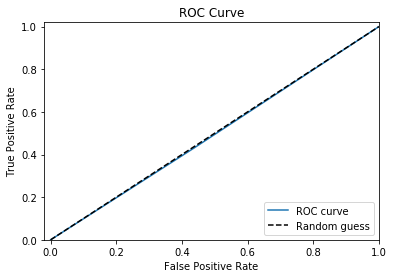

In [22]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [23]:
roc_auc_score(validation_generator.classes, y_pred)

0.49686273390602853

In [24]:
batchX, batchy = train_generator.next()
_, accuracy = model.evaluate(batchX, batchy)
print('Accuracy training: %.2f' % (accuracy*100))
batchXv, batchyv = validation_generator.next()
_, accuracy = model.evaluate(batchXv, batchyv)
print('Accuracy val: %.2f' % (accuracy*100))

128/128 [==============================] - 0s 3ms/step
Accuracy training: 80.47
128/128 [==============================] - 0s 3ms/step
Accuracy val: 78.91


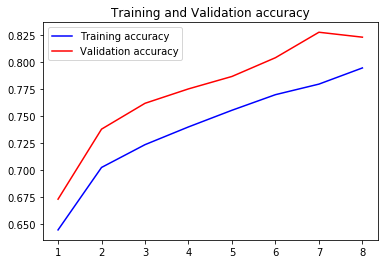

In [25]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

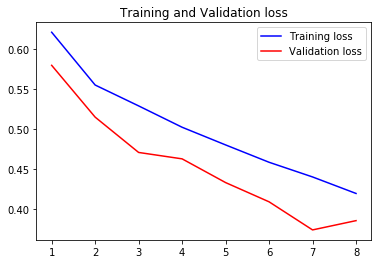

In [26]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
test_generator = test_datagen.flow_from_directory('/home/mlab/Documents/brats_hl_data/test', 
                                      class_mode='binary', 
                                      batch_size=batch_size, 
                                      target_size=(150,150))

Found 5619 images belonging to 2 classes.


In [28]:
scores = model.evaluate_generator(test_generator, steps=nb_validation_samples//batch_size)

In [29]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 81.16%


In [30]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(val_generator, 5616 // batch_size)
nb_test_samples=5619
Y_pred1 = model.predict_generator(test_generator,nb_test_samples//batch_size+1)
# y_pred = np.argmax(Y_pred,axis=1)

In [31]:
true_classes_2 = test_generator.classes
print(true_classes_2)
class_labels_2 = list(test_generator.class_indices.keys())
print(class_labels_2)

[0 0 0 ... 1 1 1]
['high', 'low']


In [32]:
# y_pred1 = (Y_pred1<0.5).astype(np.int)
y_pred1 = (Y_pred1 < 0.475).astype(np.int)
# print(y_pred)
# print('Confusion Matrix')
# print(confusion_matrix(true_classes_2, y_pred1))
# print('Classification Report')
# print(classification_report(true_classes_2, y_pred1, target_names=class_labels_2))


In [33]:
confusion_matrix1 = metrics.confusion_matrix(true_classes_2,y_pred1)
print(confusion_matrix1)

[[1574 1202]
 [1660 1183]]


In [34]:
report1= sklearn.metrics.classification_report(true_classes_2, y_pred1, 
                                               target_names = class_labels_2)
print(report1)

              precision    recall  f1-score   support

        high       0.49      0.57      0.52      2776
         low       0.50      0.42      0.45      2843

   micro avg       0.49      0.49      0.49      5619
   macro avg       0.49      0.49      0.49      5619
weighted avg       0.49      0.49      0.49      5619



In [35]:
print(" Loss: ", scores[0],"\n","Accuracy: ", scores[1])

 Loss:  0.39541898078696675 
 Accuracy:  0.8115915697674418
